In [1]:
# Data Set: FD001
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD002
# Train trajectories: 260
# Test trajectories: 259
# Conditions: SIX 
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD003
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

# Data Set: FD004
# Train trajectories: 248
# Test trajectories: 249
# Conditions: SIX 
# Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [105]:
# Reference: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import os
import shutil
import datetime
import seaborn as sns
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from category_encoders import *
from scipy.stats import pearsonr
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Restructure dataset(s)

In [3]:
train = pd.read_csv('../data/train_FD001.txt', sep=" ", header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


- last 2 cols are 'nan': drop these

In [4]:
train.drop(train.columns[-2:], axis = 1, inplace = True)

##### Rename columns:

In [5]:
cols = ['unit_num', 'cycle']
opSetCols = ['opSetting' + str(i) for i in range(1,4)]
sensorCols = ['sensor' + str(i) for i in range(1,29-7)]
cols += opSetCols + sensorCols
len(train.columns), len(cols)

(26, 26)

In [6]:
train.columns = cols
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [7]:
train.shape, len(train.unit_num.unique()), len(train.cycle.unique())

((20631, 26), 100, 362)

##### Create target variable: 
- Choose maximum cycle for all units as failure
- Reverse order of cycles and set target variable equal to 'CyclesToFailure'

In [8]:
max_cycle = train.groupby('unit_num')['cycle'].max().reset_index()
max_cycle.rename(columns={'cycle': 'max_cycle'}, inplace = True)
max_cycle.head(2)

,unit_num,max_cycle
0,1,192
1,2,287


In [9]:
train = train.merge(max_cycle, left_on='unit_num', right_on='unit_num', how='outer')
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192


In [10]:
train['CyclesToFailure'] = train.max_cycle - train.cycle
train.drop(['cycle', 'max_cycle'], axis = 1, inplace = True)
train.head(2)

,unit_num,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190


#### 2. EDA
- Feature analysis
- Correlations with target variable
- missing-values
- outliers
- etc

##### Check for nan's

In [11]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head()

In [12]:
checkMissingData(train)

,Total,Percent
CyclesToFailure,0,0.0
sensor21,0,0.0
opSetting1,0,0.0
opSetting2,0,0.0
opSetting3,0,0.0


- no missing data

##### Determine if some features are categorical or not:
- determine also whether some features are also redundant

In [13]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 1, 1, 310, 3012, 4051, 1, 2, 513, 53, 6403, 1, 159, 427, 56, 6078, 1918, 1, 13, 1, 1, 120, 4745, 

- Clearly some features are useless as they do not provide more than one type of value
    - remove columns 3, 4, 8, 13, 19, 21, 22

In [14]:
colIndicesToDrop = [3, 4, 8, 13, 19, 21, 22]
colsToDrop = []
for i, col_index in enumerate(colIndicesToDrop):
    colsToDrop.append(train.columns[col_index])
train.drop(colsToDrop, axis = 1, inplace = True)
train.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [15]:
print(train.columns)

Index(['unit_num', 'opSetting1', 'opSetting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'CyclesToFailure'],
      dtype='object')


In [16]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 310, 3012, 4051, 2, 513, 53, 6403, 159, 427, 56, 6078, 1918, 13, 120, 4745, 

##### Check correlations with target variable 
- check for individual unit_numbers

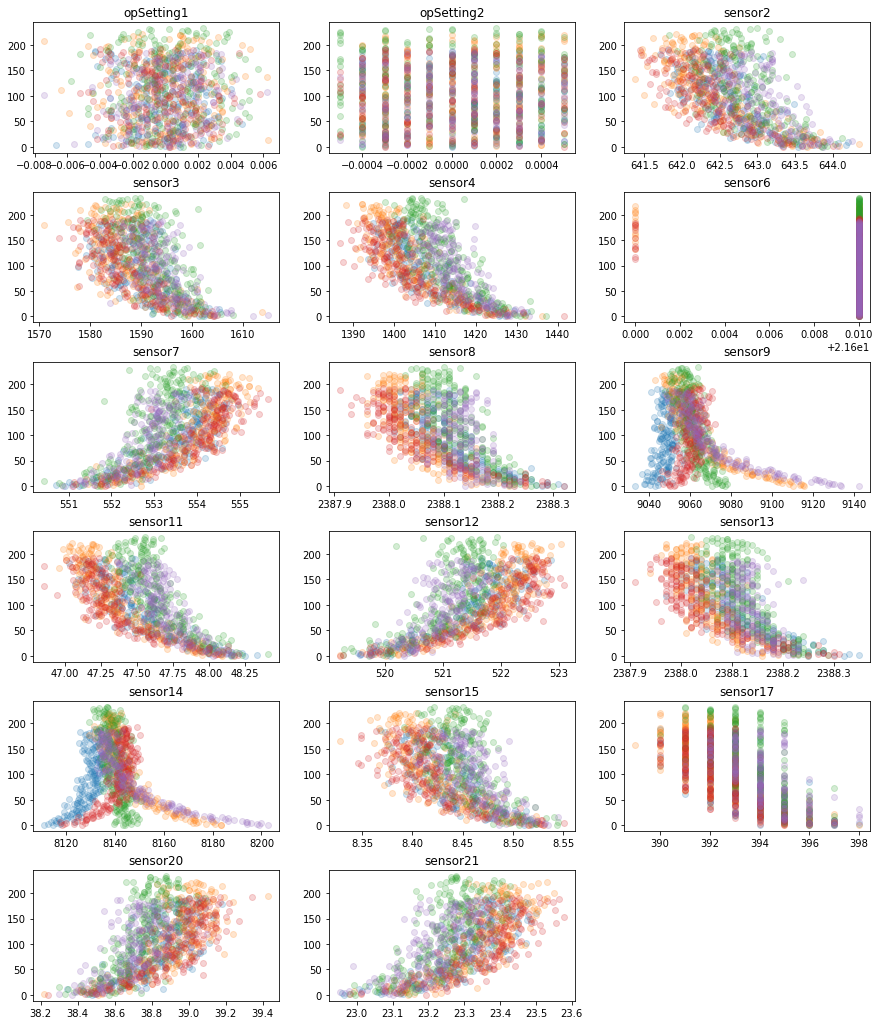

In [17]:
unit_num_list = [1, 10, 20, 30, 40]              # Selected unit-numbers

colList = train.columns[1:-1]
n_cols = 3                                       # 3 plots per row
rows = int(np.ceil(len(colList) / n_cols))    
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    
    axi = f.add_subplot(rows, n_cols, i+1)
    for i, unit_num in enumerate(unit_num_list):
        df = train[train.unit_num == unit_num]
        plt.scatter(df[col], df.CyclesToFailure, alpha = 0.2)# label = col + '_unit' + str(unit_num), alpha = 0.2)

    plt.title(col)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

- clearly sensor17 and opSetting2 are categorical variables:
        - set their values to categorical numerical values

In [18]:
le = LabelEncoder()
cat_vars = ['sensor17', 'opSetting2']
for var in cat_vars:
      train[var] = le.fit_transform(train[var])

In [19]:
train.head(2)

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,2,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,4,39.06,23.4190,191
1,1,0.0019,3,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,4,39.00,23.4236,190


In [20]:
train.dtypes

unit_num             int64
opSetting1         float64
opSetting2           int64
sensor2            float64
sensor3            float64
sensor4            float64
sensor6            float64
sensor7            float64
sensor8            float64
sensor9            float64
sensor11           float64
sensor12           float64
sensor13           float64
sensor14           float64
sensor15           float64
sensor17             int64
sensor20           float64
sensor21           float64
CyclesToFailure      int64
dtype: object

##### Heat Map

- Take unit-1 as an example

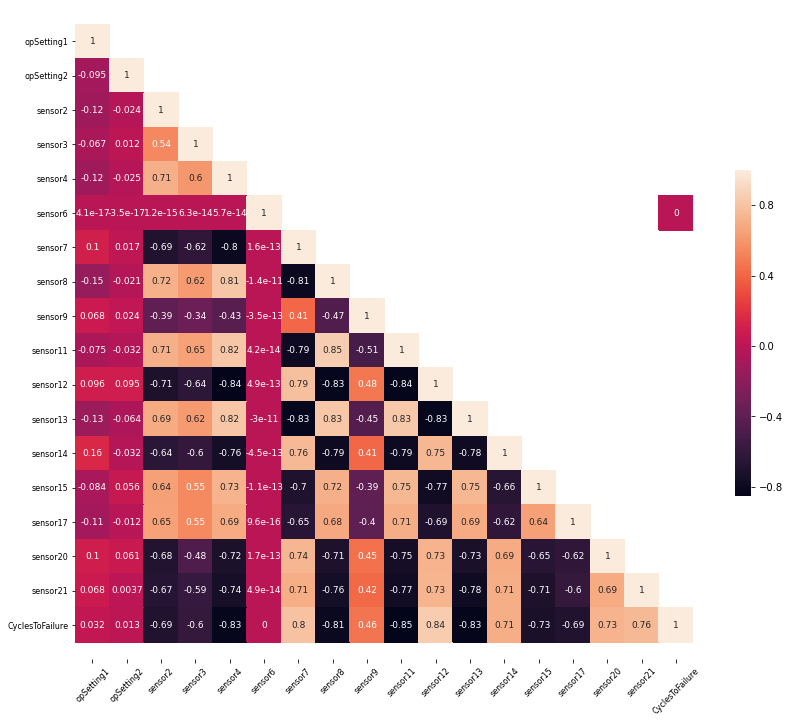

In [21]:
df = train[train.unit_num == 1]
df.drop(['unit_num'], axis = 1, inplace = True)
cor_mat= df[2:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(15,12)
ax = sns.heatmap(data=cor_mat,mask=mask,square=True,cbar_kws={"shrink": .5}, annot=True,cbar=True, annot_kws={"fontsize":9})
ylim_lower = (ax.get_ylim()[0] + 0.5)
ylim_upper = (ax.get_ylim()[1] - 0.5)
ax.set_ylim(ylim_lower, ylim_upper)
plt.xticks(rotation=45, fontsize = 8) 
_ = plt.yticks(rotation=0, fontsize = 8) 

- Sensor 6 clearly shows very little correlation with failure as seen in the scatter plot above
    - confirm with pearsons correlation for all unit-numbers:

In [21]:
train.sensor6.value_counts()

21.61    20225
21.60      406
Name: sensor6, dtype: int64

In [22]:
train.drop(['sensor6'], axis = 1, inplace = True)

- Further visualisation:
    - Scale each feature (holding unit_number constant) and then convert all to PCA 

In [23]:
def scaleData(df):
    mm = MinMaxScaler() #StandardScaler()
    df_ = df.copy()
    df_[df_.columns[1:-1]] = mm.fit_transform(df[df.columns[1:-1]])
    return df_

def convertToPCA(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['FailureGrade'] = df.FailureGrade.values
    return df_PCA

In [48]:
list_dfs = []
for unit_number in train.unit_num.unique():
    df = train[train.unit_num == unit_number]
    df_ = scaleData(df)
    list_dfs.append(df_)
    
train_ = pd.concat(list_dfs)

In [49]:
train_.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,0.526316,0.000000,0.044,0.434626,0.180277,0.859155,0.18750,0.463380,0.338462,0.639640,0.131579,0.933895,0.332039,0.250,0.857143,0.850490,191
1,1,0.754386,0.111111,0.176,0.510776,0.245506,0.715962,0.12500,0.387638,0.353846,0.825826,0.263158,0.693423,0.411650,0.250,0.785714,0.858991,190
2,1,0.210526,0.777778,0.256,0.373204,0.272727,0.835681,0.25000,0.704537,0.184615,0.867868,0.157895,0.752108,0.321036,0.000,0.726190,0.712253,189
3,1,0.649123,0.444444,0.256,0.186422,0.212892,0.880282,0.34375,0.580922,0.076923,1.000000,0.289474,0.772344,0.000000,0.250,0.642857,0.767141,188
4,1,0.421053,0.222222,0.264,0.188578,0.324602,0.774648,0.18750,0.783494,0.192308,0.798799,0.184211,0.771332,0.396117,0.375,0.666667,0.823508,187


##### Set classes as follows:
- x < 70%         CyclesToFailure 
    - normal working condition
- 70% <= x < 90% CyclesToFailure           
    - degraded working condition
- 90% <= x       CyclesToFailure           
    - failing working condition

In [50]:
list_dfs = []
for unit_number in train_.unit_num.unique():
    df = train_[train_.unit_num == unit_number]
    df['FailureGrade'] = 0
    max_cycle = max(df.CyclesToFailure)
    mod_threshold = int(0.3*max_cycle)
    fail_threshold = int(0.1*max_cycle)
    df.loc[df.CyclesToFailure <= mod_threshold, 'FailureGrade'] = 1
    df.loc[df.CyclesToFailure <= fail_threshold, 'FailureGrade'] = 2
    list_dfs.append(df)
train_ = pd.concat(list_dfs)
train_.tail()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
20626,100,0.444444,0.3,0.800000,0.590143,0.868281,0.187032,0.655172,0.635007,0.748031,0.063333,0.935484,0.187578,0.654309,0.875,0.336538,0.062636,4,2
20627,100,0.333333,0.1,0.821739,0.797456,1.000000,0.044888,0.793103,0.621099,0.724409,0.126667,0.806452,0.119255,0.745992,0.625,0.153846,0.352290,3,2
20628,100,0.518519,0.6,0.769565,0.732591,0.856307,0.064838,0.827586,0.647897,0.763780,0.236667,0.870968,0.401863,1.000000,1.000,0.288462,0.000000,2,2
20629,100,0.379630,0.9,0.686957,0.821622,0.812400,0.000000,0.862069,0.913161,1.000000,0.123333,0.838710,0.292547,0.871242,0.625,0.144231,0.203646,1,2
20630,100,0.185185,0.1,0.956522,0.666455,0.961682,0.027431,0.896552,0.497965,0.850394,0.000000,0.935484,0.170807,0.694389,0.750,0.221154,0.185260,0,2


##### Remove unit_num and convert all scaled values to 2 PCA components
- visualise their distributions according to the 3 predefined classes above 

In [51]:
train_.drop('unit_num', axis = 1, inplace = True)

- Classes are clearly quite separable (slight overlap with failure-grades '0' and '1' as seen in plot below:

<Figure size 1080x216 with 0 Axes>

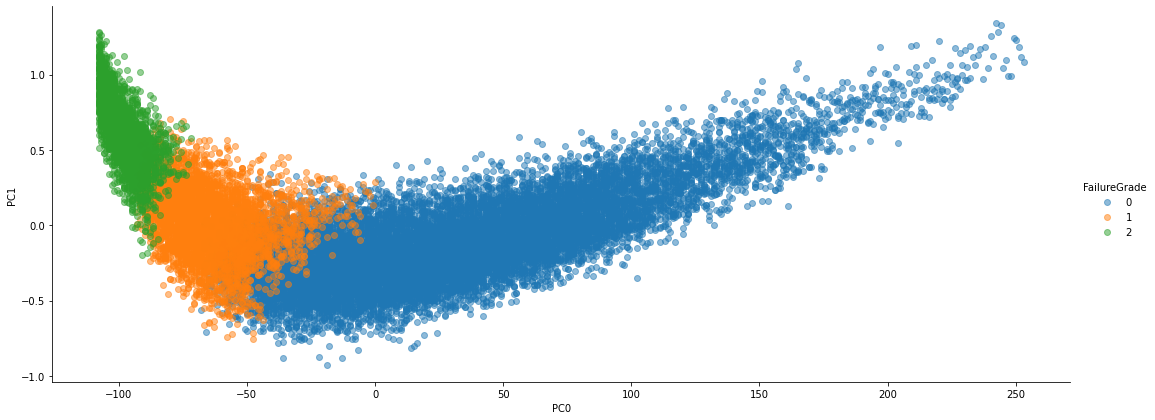

In [52]:
# Visualise failure grades through colours:
df = convertToPCA(train_, nComponents = 2)
f = plt.figure(figsize=(15,3))
explore = sns.PairGrid(data=df, x_vars = 'PC0', y_vars = 'PC1', hue="FailureGrade", size=6, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

##### 3 Component PCA

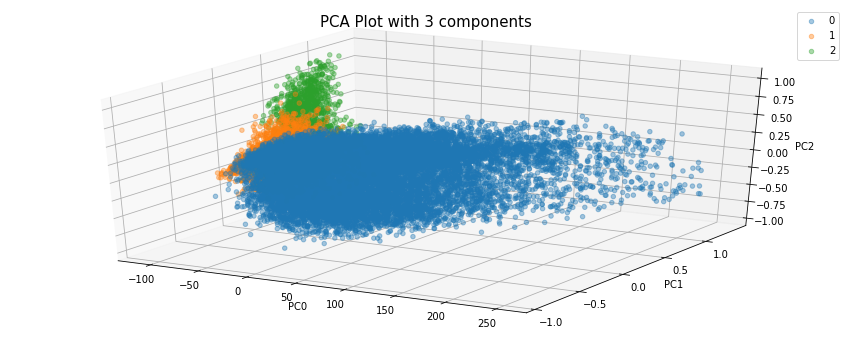

In [53]:
f = plt.figure(figsize=(15,6))
df = convertToPCA(train_, nComponents = 3)
ax = f.add_subplot(111, projection='3d')
for failure_grade in df.FailureGrade.unique():
    df_ = df[df.FailureGrade == failure_grade]
    ax.scatter(df_.PC0, df_.PC1, df_.PC2, marker='o', label = str(failure_grade), alpha = 0.4)

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.legend()
plt.title('PCA Plot with 3 components', fontsize = 15)
plt.show()

#### 3. Regression model preparation

##### Quick test of random forest model with default features:
- Explore feature importance

In [116]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def run_train_test_split(df, estimator):
    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=4, n_jobs = -1)
    
    return cval.mean()

    
    return 

## -----------------------------------------------------------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True, printFeatureImp = False, returnDataPoints = False):

    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    datapoints = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        if returnDataPoints:
            datapoints.append([[testy], [preds]])
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
        if printFeatureImp:
            print("Features sorted by their score:")
            print(sorted(zip(map(lambda x: round(x, 4), model_.feature_importances_), df.columns[:-1]), 
                 reverse=True))        
    if returnVal & returnDataPoints:
        return round(sum(rmsleScores) / n_splits, 3), datapoints
    
    elif returnVal:
        return round(sum(rmsleScores) / n_splits, 3)
    
#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------

def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   

- test model without scaling:
    - drop unit_num to avoid target leakage:

In [59]:
train.drop('unit_num', axis = 1, inplace = True)

In [60]:
rfModel = RandomForestRegressor(n_estimators=100)
#run_train_test_split(train, rfModel)testModel
testModel(train, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  41.15, 42.25, 42.17, 41.34, Average RMSLE:  41.728
Features sorted by their score:
[(0.4425, 'sensor11'), (0.1195, 'sensor9'), (0.0838, 'sensor4'), (0.0468, 'sensor12'), (0.0392, 'sensor7'), (0.0388, 'sensor14'), (0.0335, 'sensor15'), (0.0304, 'sensor21'), (0.0282, 'sensor3'), (0.0267, 'sensor2'), (0.0239, 'sensor20'), (0.0226, 'opSetting1'), (0.0209, 'sensor13'), (0.02, 'sensor8'), (0.0139, 'opSetting2'), (0.0092, 'sensor17')]


- drop opSetting variables as they may uniquely identify a unit and therefore identify give clues about failure (num_cycles etc)?
    - restest model

In [62]:
train.drop(['opSetting1', 'opSetting2'],  axis = 1, inplace = True)
rfModel = RandomForestRegressor(n_estimators=100)
#run_train_test_split(train, rfModel)testModel
testModel(train, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  41.14, 42.12, 42.15, 41.58, Average RMSLE:  41.748
Features sorted by their score:
[(0.4242, 'sensor11'), (0.1226, 'sensor9'), (0.1088, 'sensor4'), (0.048, 'sensor12'), (0.0421, 'sensor14'), (0.0411, 'sensor7'), (0.0377, 'sensor15'), (0.0331, 'sensor21'), (0.0317, 'sensor3'), (0.0295, 'sensor2'), (0.0266, 'sensor20'), (0.0227, 'sensor13'), (0.0215, 'sensor8'), (0.0103, 'sensor17')]


- Test model with scaling
    - drop class column 'FalureGrade' & opSetting columns

In [54]:
train_.drop(['FailureGrade', 'opSetting1', 'opSetting2'], axis = 1, inplace = True)

In [64]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(train_, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  35.8, 36.86, 35.82, 36.55, Average RMSLE:  36.255
Features sorted by their score:
[(0.4644, 'sensor11'), (0.0992, 'sensor4'), (0.0844, 'sensor12'), (0.0665, 'sensor7'), (0.0655, 'sensor9'), (0.0307, 'sensor14'), (0.0301, 'sensor15'), (0.0278, 'sensor20'), (0.0255, 'sensor13'), (0.0254, 'sensor21'), (0.023, 'sensor3'), (0.0224, 'sensor8'), (0.0222, 'sensor2'), (0.0129, 'sensor17')]


- considerable improvement with scaled features

##### Optimise several models with Bayesian optimisation
- choose from lightGBM, RandomForest, GradientBoost as decision-tree based algorithms
- choose from linear regression (with without penalties) i.e. Lasso, Ridge 

In [67]:
#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   Lasso optimiser   -------
def optimiseLasso(data, pbounds_):
    
    def train_bayes_opt_Lasso(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Lasso(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Lasso, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params


## -----------------------------------------------------------------------------------------------------------------------

# -------   Ridge optimiser   -------
def optimiseRidge(data, pbounds_):
    
    def train_bayes_opt_Ridge(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Ridge(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Ridge, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

##### Random Forest

In [74]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(train_, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_, n_splits = 10, model = rfModel, printFeatureImp = True)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.3493   |  44.62    |  0.007203 |  50.02    |
|  2        | -0.3453   |  33.72    |  0.001468 |  68.47    |
|  3        | -0.3453   |  22.69    |  0.003456 |  129.4    |
|  4        | -0.345    |  56.19    |  0.004192 |  187.0    |
|  5        | -0.3488   |  24.42    |  0.008781 |  55.48    |
|  6        | -0.3449   |  68.69    |  0.004173 |  161.7    |
|  7        | -0.3434   |  18.34    |  0.001981 |  210.1    |
|  8        | -0.3445   |  96.98    |  0.003134 |  188.5    |
|  9        | -0.3488   |  88.26    |  0.008946 |  67.01    |
|  10       | -0.3553   |  8.71     |  0.001698 |  225.6    |
|  11       | -0.3453   |  99.55    |  0.005485 |  249.7    |
|  12       | -0.4235   |  5.115    |  0.005598 |  175.8    |
|  13       | -0.3449   |  46.19    |  0.004018 |  250.0    |
|  14       | -0.3478   |  99.89    |  0.009434 |  119.8    |
|  15   

##### LightGBM

In [82]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1596   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.1581   |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.1793   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.1598   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.1615   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.1943   |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.1628   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.1697   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.1772   |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.1601   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.161    |  0.0      |  0.1      |  10.0     |  1e+03    |
|  12       | -0.1607   |  7.5e-11  | 

##### Scikit-learn Gradient Boosting

In [85]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1712   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.1567   |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.1717   |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.163    |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.1705   |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.1898   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.1966   |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.162    |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.2023   |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.1838   |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.1582   |  0.1      |  1.0      |  0.01     |  1e+03    |
|  12       | -0.1598   |  0.8      | 

##### Remove ordinal nature of categorical columns for linear models

- 'sensor17' is a categorical variable: 
    - Need to remove ordinal nature of data which could adversely affect linear-based techniques
        - convert to one-hot encoding
        - reduce number of dimensions through PCA (reduce risk of curse of dimensionality)

In [95]:
train_.sensor17 = train.sensor17

cat_vars = ['sensor17']
train_one = train_.copy()
for i, var in enumerate(cat_vars):
    temp = pd.get_dummies(train_one[var],prefix=var, drop_first = True )
    train_one = pd.concat([train_one,temp], axis=1)
    train_one.drop(var, axis=1, inplace = True)

print(train_one.shape)
cols = list(train_one)
cols.insert(len(cols)-1, cols.pop(cols.index('CyclesToFailure')))
train_one = train_one[cols]
train_one.head(2)

(20631, 26)


,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor20,sensor21,sensor17_1,sensor17_2,sensor17_3,sensor17_4,sensor17_5,sensor17_6,sensor17_7,sensor17_8,sensor17_9,sensor17_10,sensor17_11,sensor17_12,CyclesToFailure
0,0.044,0.434626,0.180277,0.859155,0.1875,0.463380,0.338462,0.639640,0.131579,0.933895,0.332039,0.857143,0.850490,0,0,0,1,0,0,0,0,0,0,0,0,191
1,0.176,0.510776,0.245506,0.715962,0.1250,0.387638,0.353846,0.825826,0.263158,0.693423,0.411650,0.785714,0.858991,0,0,0,1,0,0,0,0,0,0,0,0,190


##### Determine best number of components for PCA

In [96]:
def convertToPCA_reg(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['CyclesToFailure'] = df.CyclesToFailure.values
    return df_PCA

number of Components:  = 1
RMSLE Value For Kf_i:  50.37, 49.56, 49.61, 50.55, 49.48, 49.21, 51.04, 50.03, 50.69, 51.11, Average RMSLE:  50.165
Features sorted by their score:
[(1.0, 'PC0')]
number of Components:  = 2
RMSLE Value For Kf_i:  40.64, 39.83, 39.62, 41.4, 40.43, 38.74, 40.2, 40.62, 39.48, 40.62, Average RMSLE:  40.157
Features sorted by their score:
[(0.7919, 'PC0'), (0.2081, 'PC1')]
number of Components:  = 3
RMSLE Value For Kf_i:  39.65, 39.18, 38.88, 39.76, 39.3, 37.76, 39.9, 39.57, 38.37, 40.2, Average RMSLE:  39.257
Features sorted by their score:
[(0.7237, 'PC0'), (0.1567, 'PC2'), (0.1196, 'PC1')]
number of Components:  = 4
RMSLE Value For Kf_i:  39.42, 38.94, 38.41, 39.65, 39.19, 37.05, 39.35, 38.99, 38.01, 39.68, Average RMSLE:  38.867
Features sorted by their score:
[(0.6999, 'PC0'), (0.129, 'PC2'), (0.0893, 'PC3'), (0.0819, 'PC1')]
number of Components:  = 5
RMSLE Value For Kf_i:  38.87, 38.52, 37.97, 39.23, 38.78, 36.59, 38.86, 38.73, 37.63, 39.62, Average RMSLE: 

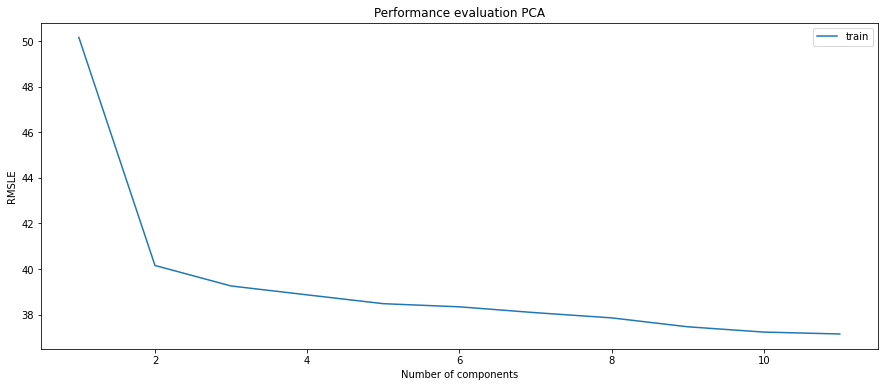

In [97]:
result = []
scaled_result = []
for nComponents in range(1, 15):
    print("{} = {}".format('number of Components: ', nComponents))
    df_PCA_one = convertToPCA_reg(train_one, nComponents)
    
    # Presaved Random Forest Regressor max_params:
    max_params['params'] = {'min_impurity_decrease': 0.00037466493803095416, 'max_depth': 39, 'n_estimators': 129}
    rfModel = RandomForestRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_one, n_splits = 10, model = rfModel, returnVal = True, printFeatureImp = True)
    result.append(newVal)
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'train')
plt.legend()

_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

number of Components:  = 12
RMSLE Value For Kf_i:  37.12, 36.72, 37.05, 37.5, 37.67, 35.51, 37.36, 37.24, 35.68, 37.98, Average RMSLE:  36.984
Features sorted by their score:
[(0.6574, 'PC0'), (0.0611, 'PC2'), (0.0442, 'PC6'), (0.0325, 'PC8'), (0.0313, 'PC9'), (0.0298, 'PC4'), (0.0287, 'PC10'), (0.0275, 'PC11'), (0.0263, 'PC7'), (0.0211, 'PC3'), (0.0201, 'PC1'), (0.0198, 'PC5')]
number of Components:  = 13
RMSLE Value For Kf_i:  37.12, 36.82, 36.98, 37.49, 37.26, 35.49, 37.26, 37.45, 35.62, 38.0, Average RMSLE:  36.95
Features sorted by their score:
[(0.6567, 'PC0'), (0.0597, 'PC2'), (0.0419, 'PC6'), (0.0302, 'PC8'), (0.0288, 'PC9'), (0.0283, 'PC4'), (0.0266, 'PC10'), (0.0239, 'PC7'), (0.0235, 'PC12'), (0.023, 'PC11'), (0.0204, 'PC3'), (0.0185, 'PC5'), (0.0184, 'PC1')]
number of Components:  = 14
RMSLE Value For Kf_i:  36.96, 36.45, 36.95, 37.55, 37.33, 35.41, 37.39, 37.18, 35.99, 37.76, Average RMSLE:  36.896
Features sorted by their score:
[(0.6547, 'PC0'), (0.058, 'PC2'), (0.0406, '

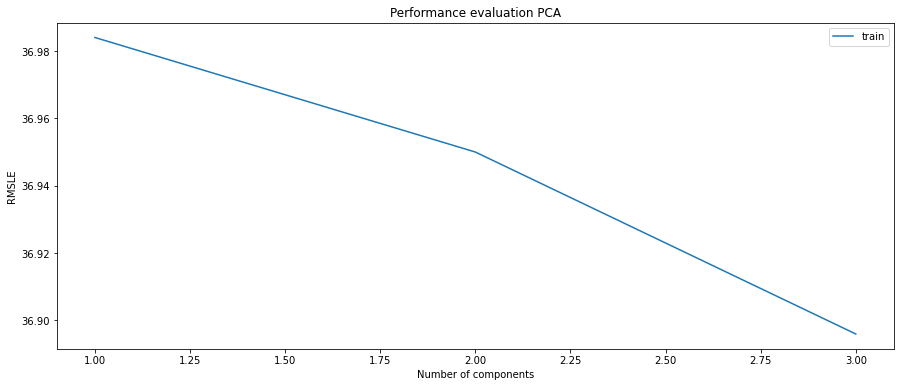

In [100]:
result = []
scaled_result = []
for nComponents in range(12, 15):
    print("{} = {}".format('number of Components: ', nComponents))
    df_PCA_one = convertToPCA_reg(train_one, nComponents)
    
    # Presaved Random Forest Regressor max_params:
    max_params['params'] = {'min_impurity_decrease': 0.00037466493803095416, 'max_depth': 39, 'n_estimators': 129}
    rfModel = RandomForestRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_one, n_splits = 10, model = rfModel, returnVal = True)
    result.append(newVal)
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'train')
plt.legend()

_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

##### Linear regression with/ without penalties and 14 principal components

In [102]:
df_PCA_one.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,CyclesToFailure
0,-0.649462,-0.603851,-0.395242,-0.185315,-0.515290,-0.224844,0.029476,-0.025623,0.103591,0.172121,-0.178239,0.036876,-0.032004,0.155459,191
1,-0.586481,-0.595611,-0.399417,-0.213337,-0.289171,-0.119822,-0.002305,-0.026960,0.159097,0.134956,-0.098468,0.005845,-0.073465,0.214295,190
2,-0.301233,-0.077594,0.067601,0.270296,-0.510276,-0.247186,0.455577,0.877866,0.001328,0.130184,0.011543,-0.364342,0.071507,0.005977,189
3,-0.759644,-0.602527,-0.361755,-0.176407,-0.448431,-0.226544,0.049948,-0.031568,-0.248242,0.107928,0.028101,0.037812,-0.094669,-0.235120,188
4,-0.427052,0.748917,-0.060909,-0.073832,-0.588654,-0.285631,0.070646,-0.028355,-0.099662,-0.122416,-0.095606,0.004114,-0.101242,0.101548,187


In [103]:
df_PCA_one_ = df_PCA_one.copy()

##### Linear regression

In [108]:
lModel = LinearRegression()
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lModel)

RMSLE Value For Kf_i:  39.7, 38.96, 39.44, 39.57, 40.09, 37.95, 40.64, 40.11, 38.27, 40.34, Average RMSLE:  39.506


##### Lasso regression

In [109]:
bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseLasso(df_PCA_one, bounds_)
lassoModel = Lasso(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lassoModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.1922   |  0.417    |
|  2        | -0.191    |  0.7203   |
|  3        | -0.1983   |  0.000114 |
|  4        | -0.193    |  0.3023   |
|  5        | -0.1948   |  0.1468   |
|  6        | -0.1958   |  0.09234  |
|  7        | -0.1943   |  0.1863   |
|  8        | -0.1926   |  0.3456   |
|  9        | -0.1922   |  0.3968   |
|  10       | -0.1917   |  0.5388   |
|  11       | -0.1895   |  1.0      |
|  12       | -0.1895   |  1.0      |
|  13       | -0.1895   |  1.0      |
|  14       | -0.1895   |  1.0      |
|  15       | -0.1895   |  0.9999   |
|  16       | -0.1895   |  1.0      |
|  17       | -0.1895   |  1.0      |
|  18       | -0.1895   |  0.9999   |
|  19       | -0.1895   |  1.0      |
|  20       | -0.1895   |  0.9998   |
|  21       | -0.1895   |  1.0      |
|  22       | -0.1895   |  0.9998   |
|  23       | -0.1895   |  0.9999   |
|  24       | -0.1895   |  1.0      |
|  25       

##### Ridge regression

In [110]:
bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseRidge(df_PCA_one, bounds_)
ridgeModel = Ridge(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.1983   |  0.417    |
|  2        | -0.1982   |  0.7203   |
|  3        | -0.1983   |  0.000114 |
|  4        | -0.1983   |  0.3023   |
|  5        | -0.1983   |  0.1468   |
|  6        | -0.1983   |  0.09234  |
|  7        | -0.1983   |  0.1863   |
|  8        | -0.1983   |  0.3456   |
|  9        | -0.1983   |  0.3968   |
|  10       | -0.1983   |  0.5388   |
|  11       | -0.1983   |  0.1418   |
|  12       | -0.1982   |  0.7309   |
|  13       | -0.1983   |  0.3906   |
|  14       | -0.1982   |  0.7741   |
|  15       | -0.1983   |  0.3443   |
|  16       | -0.1983   |  0.1676   |
|  17       | -0.1982   |  0.7919   |
|  18       | -0.1983   |  0.6207   |
|  19       | -0.1983   |  0.5876   |
|  20       | -0.1982   |  0.8021   |
|  21       | -0.1982   |  0.7491   |
|  22       | -0.1982   |  0.7675   |
|  23       | -0.1983   |  0.2656   |
|  24       | -0.1983   |  0.07031  |
|  25       

##### lightGBM was best performing:
- lets see how the predictions faired:

In [111]:
Final result: {'target': -0.15811934861343782, 'params': }

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,CyclesToFailure
0,-0.649462,-0.603851,-0.395242,-0.185315,-0.515290,-0.224844,0.029476,-0.025623,0.103591,0.172121,-0.178239,0.036876,-0.032004,0.155459,191
1,-0.586481,-0.595611,-0.399417,-0.213337,-0.289171,-0.119822,-0.002305,-0.026960,0.159097,0.134956,-0.098468,0.005845,-0.073465,0.214295,190
2,-0.301233,-0.077594,0.067601,0.270296,-0.510276,-0.247186,0.455577,0.877866,0.001328,0.130184,0.011543,-0.364342,0.071507,0.005977,189
3,-0.759644,-0.602527,-0.361755,-0.176407,-0.448431,-0.226544,0.049948,-0.031568,-0.248242,0.107928,0.028101,0.037812,-0.094669,-0.235120,188
4,-0.427052,0.748917,-0.060909,-0.073832,-0.588654,-0.285631,0.070646,-0.028355,-0.099662,-0.122416,-0.095606,0.004114,-0.101242,0.101548,187


In [117]:
max_params['params'] = {'gamma': 0.14675589081711304, 'learning_rate': 0.16463701633815847, 'max_depth': 3, 'n_estimators': 378}
lgbmMod = LGBMRegressor(**max_params['params'])
newVal, datapoints = testModel(df = train_, n_splits = 10, model = lgbmMod, returnVal = True, returnDataPoints = True)

RMSLE Value For Kf_i:  34.75, 33.47, 33.85, 34.32, 34.05, 33.02, 34.09, 33.63, 33.26, 35.01, Average RMSLE:  33.944


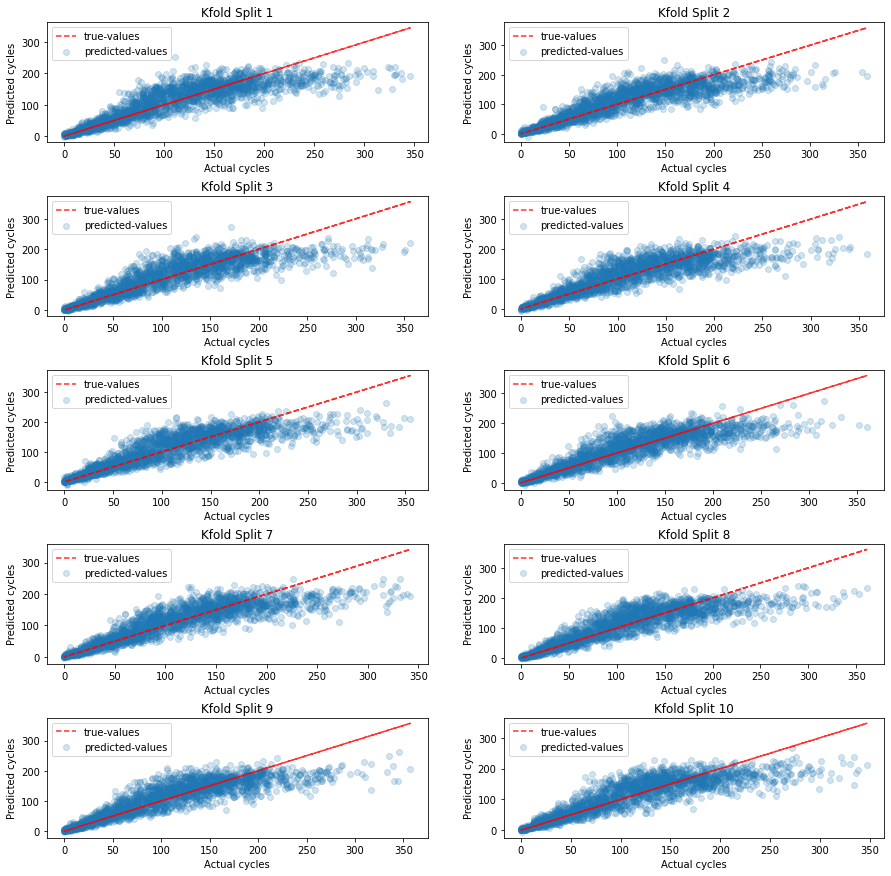

In [134]:
n_cols = 2                                       # 2 plots per row
rows = int(np.ceil(len(datapoints) / n_cols))
f = plt.figure(figsize=(15,3*rows))

for i in range(len(datapoints)):
    truePoints = datapoints[i][0]
    predPoints = datapoints[i][1]
    axi = f.add_subplot(rows, n_cols, i+1)
    plt.plot(datapoints[i][0][0], datapoints[i][0][0], 'r--', alpha = 0.8, label ='true-values')
    plt.scatter(datapoints[i][0], datapoints[i][1], alpha = 0.2, label ='predicted-values')
    axi.set_xlabel('Actual cycles')
    axi.set_ylabel('Predicted cycles')
    plt.title('Kfold Split ' + str(i+1), fontsize = 12)
    plt.legend()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.45)

#### 4. Classification model preparation

- Try and predict one of 3 classes or **FailureGrades** 
- Drop CyclesToFailure target and replace with above mentioned class target
- Try predict 3 classes and compare results with reducing to a 2-class problem

# SHUFFLE DATASET AND RERUN CODE - FEATURE IMPORTANCE STUFF NEEDS TO BE REMOVED TOO

##### Drop 'opSetting1' and 'opSetting2' given they provide little information:
- Check if they are engaged more/less at different stages of wear

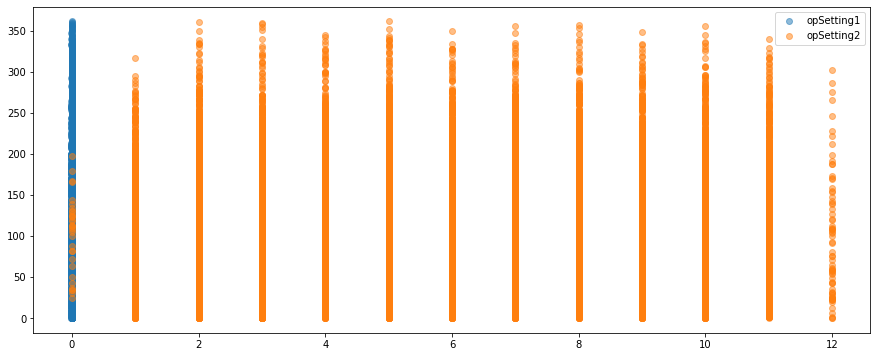

In [86]:
cols = ['opSetting1', 'opSetting2']
f = plt.figure(figsize=(15,6))

for col in cols:
    plt.scatter(train_[col], train_.CyclesToFailure, label = col, alpha = 0.5)
plt.legend()

In [ ]:
#### Remove 'opSetting1' & 'opSetting2' as 

#### Survival analysis needs constant behaviour of covariates with time! No changes allowed!

In [ ]:

['sensor' + str(i) for i in range(1,29-7)]
#colsToDrop = 
#[train.columns[]]
#train.drop